# Task 2 - GA-trained 3-layer MLP for Breast Cancer Diagnosis
This notebook follows the assignment brief for task 2: train a minimal 3-layer MLP (input, hidden, and output layer) using a Genetic Algorithm on the Breast Cancer Wisconsin Diagnostic dataset. In this notebook there are also explanations that emphasize the data preparation, GA operators, and what the reported metrics tell us.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo # Fetches the dataset from UCI ML Repo

# Random number generator for reproducibility
rng = np.random.default_rng(42)

## Dataset and Preprocessing
- Source: Breast Cancer Wisconsin Diagnostic (UC Irvine, id = 17) fetched via `ucimlrepo`.
- Label mapping: malignant -> 1, benign -> 0.
- Split: 80% train, 20% test (random permutation).
- Scaling: z-score standardization using training mean/std only; applied to both train and test to avoid leakage.

In [2]:
# Pullingin the dataset from UCI ML Repo
dataset = fetch_ucirepo(id = 17)

print(dataset.metadata) # Metadata dump - helps to inspect structure
print(dataset.variables) # Columns and their types

X_df = dataset.data.features
y_raw = dataset.data.targets.squeeze()

# Convertingm labels: "M" = Malignant (1.0), "B" = Benign (0.0)
if getattr(y_raw, "dtype", None) and y_raw.dtype.kind in {"O", "U", "S"}:
    y = (y_raw == "M").astype(float).to_numpy()
else:
    y = y_raw.to_numpy(dtype = float)

X = X_df.to_numpy(dtype = float)

# 80/20 train-test split
total = len(X)
indices = rng.permutation(total)
split_at = int(0.8 * total)

train_index = indices[:split_at]
test_index = indices[split_at:]

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

# Normalization using training data statistics
train_mean = X_train.mean(axis = 0)
train_std = X_train.std(axis = 0) + 1e-8 # Adding epsilon to avoid division by zero

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

print(f"Train set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples, Features: {X_train.shape[1]}")

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

## Dataset Visuals
A quick sanity check of the data before training:
- Class balance plot shows benign vs malignant counts.
- A two-feature scatter (radius_mean vs texture_mean) shows separability.
- A correlation heatmap for the first ten features highlights redundancy and scale differences.

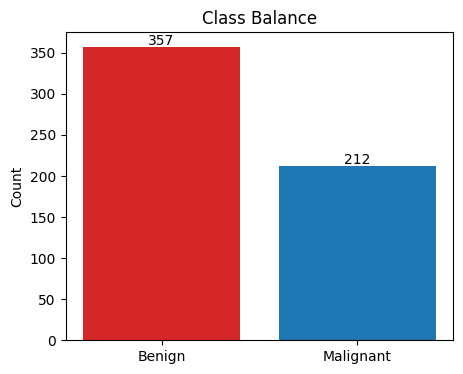

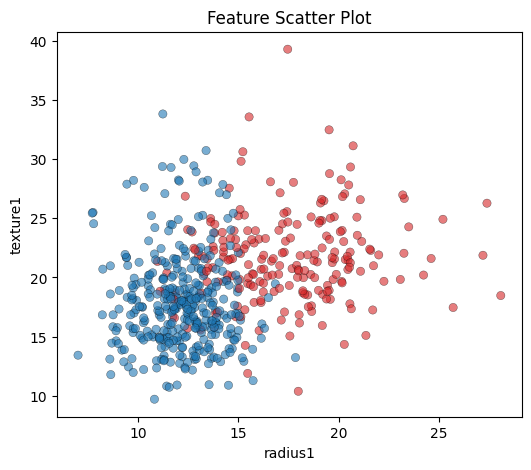

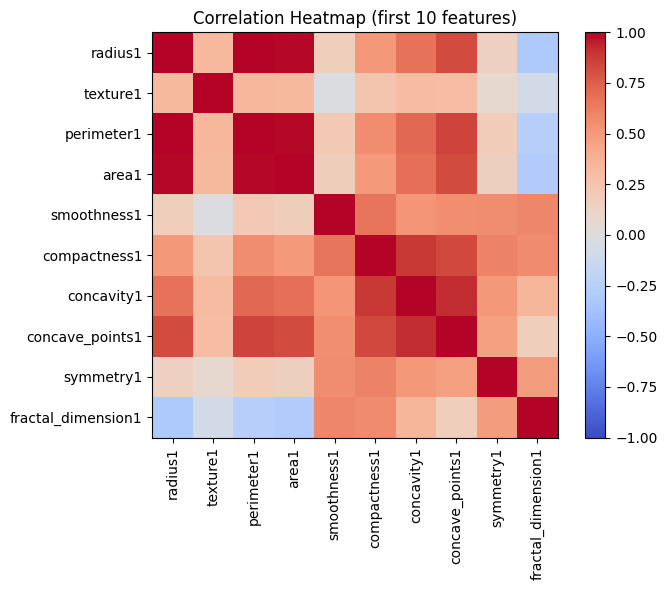

In [3]:
# Class balance plot
label_map = {0.0: "Benign", 1.0: "Malignant"}
label_counts = pd.Series(y).map(label_map).value_counts()

plt.figure(figsize = (5, 4))
plt.bar(label_counts.index, label_counts.values, color = ["#d62728", "#1f77b4"])
plt.ylabel("Count")
plt.title("Class Balance")

for index, value in enumerate(label_counts.values):
    plt.text(index, value + 2, str(int(value)), ha = "center")
plt.show()

# Two-feature scatter plot
feature_x = "radius_mean" if "radius_mean" in X_df.columns else X_df.columns[0]
feature_y = "texture_mean" if "texture_mean" in X_df.columns else X_df.columns[1]

colors = np.where(y == 1.0, "#d62728", "#1f77b4")
plt.figure(figsize = (6, 5))
plt.scatter(X_df[feature_x], X_df[feature_y], c = colors, alpha = 0.6, edgecolor = "k", linewidth = 0.3)
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title("Feature Scatter Plot")
plt.show()

# Correlation heatmap for the first 10 features
sample_cols = list(X_df.columns[:10])
corr = X_df[sample_cols].corr(numeric_only = True)

plt.figure(figsize = (8, 6))
im = plt.imshow(corr, cmap = "coolwarm", vmin = -1, vmax = 1)
plt.colorbar(im, fraction = 0.046, pad = 0.04)
plt.xticks(range(len(sample_cols)), sample_cols, rotation = 90)
plt.yticks(range(len(sample_cols)), sample_cols)
plt.title("Correlation Heatmap (first 10 features)")
plt.tight_layout()
plt.show()

## Model Representation and Fitness
- Architecture: 30 inputs (dataset features) -> 12 ReLU hidden units -> 1 sigmoid output (binary probability).
- Parameterization: all weights and biases are flattened into one genome so the GA can evolve them.
- Fitness: based on binary cross-entropy loss on the training set, transformed to `1 / (1 + loss)` so higher is better. This keeps the GA objective aligned with minimizing classification error.

In [4]:
# MLP layer sizes
input_size = X_train.shape[1]
hidden_size = 12
output_size = 1

# Define genome length (flattened weights/biases)
sizes = {
    "W1": input_size * hidden_size,
    "b1": hidden_size,
    "W2": hidden_size * output_size,
    "b2": output_size
}
genome_length = sum(sizes.values())

# Activation functions
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Decode weights from flat vector to matrices
def unpack_weights(vector):
    ptr = 0
    W1 = vector[ptr : ptr + sizes["W1"]].reshape(input_size, hidden_size)
    ptr += sizes["W1"]
    b1 = vector[ptr : ptr + sizes["b1"]]
    ptr += sizes["b1"]
    W2 = vector[ptr : ptr + sizes["W2"]].reshape(hidden_size, output_size)
    ptr += sizes["W2"]
    b2 = vector[ptr : ptr + sizes["b2"]]
    return W1, b1, W2, b2

def forward_pass(vector, X):
    W1, b1, W2, b2 = unpack_weights(vector)
    hidden = relu(X @ W1 + b1)
    output = sigmoid(hidden @ W2 + b2)
    return output.reshape(-1)

# Loss function: binary cross-entropy
def binary_cross_entropy(preds, targets):
    epsilon = 1e-8
    preds = np.clip(preds, epsilon, 1 - epsilon)
    return -np.mean(targets * np.log(preds) + (1 - targets) * np.log(1 - preds))

def fitness(vector):
    preds = forward_pass(vector, X_train)
    loss = binary_cross_entropy(preds, y_train)
    return 1 / (1 + loss)

# Accuracy check
def accuracy_for(vector, X, y):
    preds = forward_pass(vector, X)
    predicted_labels = (preds >= 0.5).astype(float)
    return (predicted_labels == y).mean()

## Genetic Algorithm Design
- Selection: tournament of size 3; favors stronger individuals while preserving diversity.
- Crossover: uniform gene-wise mixing between two parents to combine traits.
- Mutation: Gaussian noise applied sparseky to weights/biases to escape local optima.
- Elitism: top genomes are copied to the next generation unmodified.
- Practical notes: modest population (40) and generations (60) keep runtime reasonable for this small dataset.

In [5]:
# GA hyperparameters
population_size = 40
elite_size = 2
tournament_k = 3
mutation_rate = 0.1
mutation_scale = 0.3
generations = 60

def initialize_population():
    # Randomly sampled individuals
    return [rng.normal(0, 1, genome_length) for _ in range(population_size)]

def select_parent(population, fitnesses):
    # Tournament selection
    contenders = rng.choice(len(population), size = tournament_k, replace = False)
    best = contenders[np.argmax(fitnesses[contenders])]
    return population[best]

def crossover(parent1, parent2):
    # Random uniform crossover
    mask = rng.random(genome_length) < 0.5
    return np.where(mask, parent1, parent2)

def mutate(child):
    # Add random noise to selected genes
    mask = rng.random(genome_length) < mutation_rate
    noise = rng.normal(0, mutation_scale, genome_length)
    mutated = child.copy()
    mutated[mask] += noise[mask]
    return mutated

# Main GA loop
population = initialize_population()
history = []
best_vector = None
best_fitness = -np.inf

for gen in range(generations):
    fitnesses = np.array([fitness(indiv) for indiv in population])
    sorted_indices = np.argsort(-fitnesses)
    population = [population[i] for i in sorted_indices]
    fitnesses = fitnesses[sorted_indices]
    
    if fitnesses[0] > best_fitness:
        best_fitness = fitnesses[0]
        best_vector = population[0].copy()
    
    history.append(best_fitness)
    print(f"Genration {gen + 1:02d}: Best Fitness: {fitnesses[0]:.4f}")
    
    new_population = population[:elite_size] # Keep elites
    
    # Fill rest of population
    while len(new_population) < population_size:
        parent1 = select_parent(population, fitnesses)
        parent2 = select_parent(population, fitnesses)
        child = crossover(parent1, parent2)
        child = mutate(child)
        new_population.append(child)
    
    population = new_population

Genration 01: Best Fitness: 0.4873
Genration 02: Best Fitness: 0.6171
Genration 03: Best Fitness: 0.6384
Genration 04: Best Fitness: 0.6700
Genration 05: Best Fitness: 0.7291
Genration 06: Best Fitness: 0.7355
Genration 07: Best Fitness: 0.7355
Genration 08: Best Fitness: 0.7633
Genration 09: Best Fitness: 0.7857
Genration 10: Best Fitness: 0.8011
Genration 11: Best Fitness: 0.8011
Genration 12: Best Fitness: 0.8131
Genration 13: Best Fitness: 0.8433
Genration 14: Best Fitness: 0.8433
Genration 15: Best Fitness: 0.8505
Genration 16: Best Fitness: 0.8505
Genration 17: Best Fitness: 0.8505
Genration 18: Best Fitness: 0.8825
Genration 19: Best Fitness: 0.8825
Genration 20: Best Fitness: 0.8825
Genration 21: Best Fitness: 0.8966
Genration 22: Best Fitness: 0.8966
Genration 23: Best Fitness: 0.8966
Genration 24: Best Fitness: 0.8966
Genration 25: Best Fitness: 0.9022
Genration 26: Best Fitness: 0.9022
Genration 27: Best Fitness: 0.9117
Genration 28: Best Fitness: 0.9117
Genration 29: Best F

## Evaluation Outputs
We report training and test accuracy from the best genome found after GA evolution. Because the GA is stochastic, reruns may vary slightly; the printed fitness value shows the best objective achieved on the training split.

In [6]:
# Final accuracy and fitness reporting
train_accuracy = accuracy_for(best_vector, X_train, y_train)
test_accuracy = accuracy_for(best_vector, X_test, y_test)

print(f"Best Fitness Score: {best_fitness:.4f}")
print(f"Train Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Total Generations: {generations}")

Best Fitness Score: 0.9730
Train Accuracy: 0.987
Test Accuracy: 0.974
Total Generations: 60


## GA Progress Plots
Two quick diagnostics: (1) best fitness vs generation to confirm the GA is improving, and (2) training vs testing accuracy bars to check for overfitting. Steady upward fitness with close training/testing accuracies suggests the simple model generalizes well.

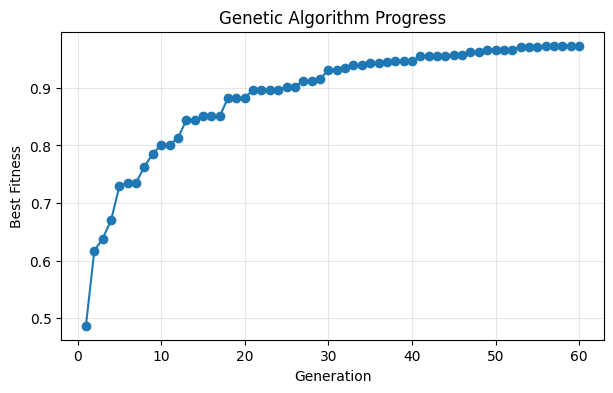

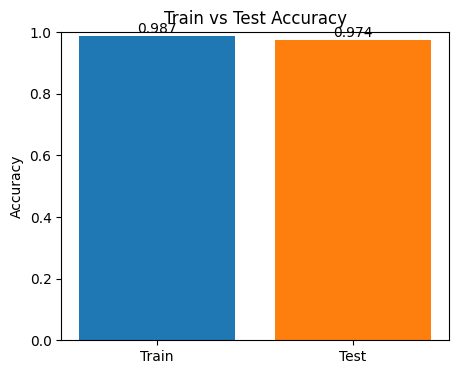

In [7]:
# Best Fitness vs Generation Plot
plt.figure(figsize = (7, 4))
plt.plot(range(1, len(history) + 1), history, marker = "o", linewidth = 1.5)
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Genetic Algorithm Progress")
plt.grid(alpha = 0.3)
plt.show()

# Training vs Testing Accuracy Bars
plt.figure(figsize = (5, 4))
plt.bar(["Train", "Test"], [train_accuracy, test_accuracy], color = ["#1f77b4", "#ff7f0e"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy")
for index, value in enumerate([train_accuracy, test_accuracy]):
    plt.text(index, value + 0.01, f"{value:.3f}", ha = "center")
plt.show()